##  Homework 2
Bryan Mahoney

Helicopter Aerodynamics

October 15, 2016

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

### Problem 1

Given a helicopter of weight, W = 6000 lb, calculate the power required in hover and at
rates of climb (V c ) of 300, 600, -300, and -600 ft/min. The radius of main rotor is 21 ft and
the rotor has a figure of merit of 0.75. Calculate your results at mean sea level conditions,
and for density altitudes of five thousand and ten thousand feet. Plot your results in the
form of power required versus climb velocity. Discuss the factors that will determine the
maximum vertical climb rate of a helicopter.
For negative V c check if -2 ≤ V c /v h ≤ 0. If yes, use the empirical relation for
calculating v i /v h .

In [81]:
R = 21 # Ft
W = 6000  # lbf
V_c = np.array([-600,-300,300,600]) # ft/min

R = R * 0.305  # feet to meters
W = W * 4.448 # lbf to Newtons
V_c = V_c * 0.305 / 60 # feet/min to meters/min

rho = np.array([1.225, 1.055, 0.9046]) # kg/m^3, std atmosphere at 0, 5000, and 10,000ft
V_c

array([-3.05 , -1.525,  1.525,  3.05 ])

In [82]:
A = np.pi * R**2
V_h = np.sqrt(W / ( 2 * rho * A))
P_h = W * V_h  # Should be in Watts
print V_h, P_h   # m/s, Watts

[  9.19350045   9.9065564   10.69844491] [ 245356.14012446  264386.17720166  285520.09764486]


Building a 4x3 array of the $\frac{V_c}{V_h}$ ratios for each altitude(row) and each speed(column).

In [83]:
V_climb_ratio = np.zeros((3,4))

for i in xrange(0,3):  # Rows
    for j in xrange(0,4):   # Columns
        V_climb_ratio[i][j] = V_c[j] / V_h[i]
        
V_climb_ratio

array([[-0.33175612, -0.16587806,  0.16587806,  0.33175612],
       [-0.30787691, -0.15393846,  0.15393846,  0.30787691],
       [-0.28508816, -0.14254408,  0.14254408,  0.28508816]])

Power required for the climb cases:

$$\frac{P_r}{P_h} = \frac{V_c}{2 V_h} + \sqrt{(\frac{V_c}{V_h})^2 + 1}$$



In [84]:
P_r = np.zeros((3,4))

for i in xrange(0,3):  # rows; 1 for each density
    for j in xrange(0,4):  # columns; 1 for each ascension rate
        if V_climb_ratio[i][j] > 0:
            P_r[i][j] = P_h[i] * ( 0.5 * V_climb_ratio[i][j] + np.sqrt(V_climb_ratio[i][j]**2 + 1))
            
print P_r

[[      0.               0.          269058.38628913  299205.16708651]
 [      0.               0.          287850.02163695  317332.0798568 ]
 [      0.               0.          308755.8257299   337595.52143509]]


To calculate induced velocity in the descent cases, since they're not in the 'Windmill Brake State', use the following empirical relation:

$$ \frac{V_i}{V_h} = k + k_1 (\frac{V_c}{V_h}) + k_2 (\frac{V_c}{V_h})^2 + k_3 (\frac{V_c}{V_h}) ^ 3 + k_4 (\frac{V_c}{V_h}) ^ 4, $$ 

with k = 1, k_1 = -1.125, k_2 = -1.372, k_3 = -1.718, k_4 = -0.655.



To then compute power required, use:

$$ \frac{P}{P_h} = \frac{V_c + V_i}{V_h}. $$


In [85]:
k = np.array([1., -1.125, -1.372, -1.718, -0.655])

def get_Vi_ratio(V_climb_ratio):
    return k[0] + k[1] * V_climb_ratio + k[2] * V_climb_ratio**2 + k[3] * V_climb_ratio**3 \
        + k[4] * V_climb_ratio **4
    
Vi = np.zeros((3,2)) 

for i in xrange(0,3):
    Vi[i][:] = V_h[i] * get_Vi_ratio(V_climb_ratio[i][:2])
    
print Vi # Induced velocities, m/s

[[ 11.74025291  10.62958902]
 [ 12.48784479  11.35853727]
 [ 13.31630012  12.16616614]]


In [86]:
for i in xrange(0,3):  # Iterating over rows(again...)
    for j in xrange(0,2):
        P_r[i][j] = P_h[i] * ( V_c[j] + Vi[i,j]) / V_h[i]
        
P_r = P_r / 745.7  #  Watts to Horsepower conversion
print P_r  #  Rows are different altitudes, columns are different velocities

[[ 311.01712439  325.84587869  360.81317727  401.24066929]
 [ 337.77283342  351.93434701  386.01317103  425.54925554]
 [ 367.42257968  380.83873116  414.04831129  452.72297363]]


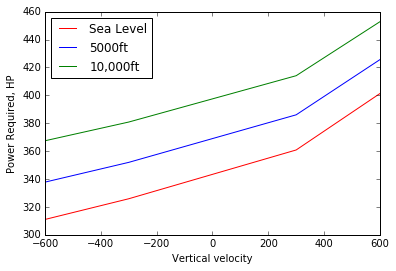

In [87]:
fig, axes = plt.subplots()

V_c = np.array([-600, -300, 300, 600]) # Returning to ft/min 

axes.plot(V_c,P_r[0],'-r',label='Sea Level')
axes.plot(V_c,P_r[1],'-b',label='5000ft')
axes.plot(V_c,P_r[2],'-g',label='10,000ft')

axes.set_xlabel('Vertical velocity')
axes.set_ylabel('Power Required, HP')

axes.legend(loc=0);

**Discussion:**  For a given engine configuration, the altitude will limit the vertical climb rate in much the same way that it does an aircraft.  The air gets thinner, and so the momentum imparted to the air is less for a given amount of power.  Less lift(thrust here) can be generated for a given amount of power.

### Problem 2:
Starting from the momentum theory result for the induced flow at the rotor disk in forward
flight, program numerical solutions to this inflow equation using both the fixed-point (FP)
iterative method and the Newton-Raphson (NR) method. Compare your numerical results
with the exact analytic result for the case where rotor disk angle of attack (α) is zero. Plot
analytic theory as a curve and numerical solution as discrete points with symbols. For both
numerical methods, explore the effect of the initial guess for λ on the results from the
numerical solution. [Assume $C_T = 0.01$]

***********
Essentially, this problem is asking me to solve for $\lambda$ in the implicit function 
$$\lambda = \mu   tan (\alpha) + \frac{C_T}{2 \sqrt(\mu^2 + \lambda^2) } + \lambda_c cos (\alpha), $$

where $\lambda_c = \frac{V_c}{\Omega R}$, and $\mu$, the inflow ratio, is equal to $ \frac{V_{\infty}}{\Omega R}.$ 







Expectations:

 * Advance ratio, $\mu$, is between 0 and 0.7
 * Alpha is small, ($\pm 10^{ \circ}$) to avoid stall
 * Since we're in strictly forward flight, $\lambda_c = 0$.

**Fixed Point**

In [88]:
def lambda_(alpha, C_T, mu, lambda_guess, lambda_c):  #  Cannot simply use 'lambda' since that's a python reserved word.
    return mu * np.tan(np.degrees(alpha) ) + C_T/ ( 2 * np.sqrt(mu**2 + C_T**2)) + lambda_c * np.cos(alpha)


C_T = 0.01 # Given in problem statement
alpha = 0.0
mu = 0.0
lambda_c = 0.0

In [89]:
max_iter = 10

lambda_fp = np.zeros((3,max_iter))
lambda_h = np.sqrt(C_T / 2)
lambda_analytic = np.sqrt(- 0.5 * (mu/lambda_h)**2 + np.sqrt((1/4) * (mu/lambda_h)**4 + 1)) * lambda_h * np.ones(max_iter)


# Fixed point
lambda_fp[0,0] = lambda_h
lambda_fp[1,0] = 0.5
lambda_fp[2,0] = 0.1


for n in xrange(1,max_iter):
    #print n
    lambda_fp[0][n] = lambda_(alpha, C_T, mu,lambda_fp[0,n-1], lambda_c)
    lambda_fp[1][n] = lambda_(alpha, C_T, mu,lambda_fp[1,n-1], lambda_c)
    lambda_fp[2][n] = lambda_(alpha, C_T, mu,lambda_fp[2,n-1], lambda_c)
    



** Newton Raphson**
$$ \lambda_{n+1} = \lambda_n - \frac{f(\lambda_n)}{f(\lambda_n)} $$

where $f(\lambda) = \lambda -(\mu   tan (\alpha) + \frac{C_T}{2 \sqrt(\mu^2 + \lambda^2) } + \lambda_c cos (\alpha)). $

In [90]:
def f(alpha,C_T, mu, lambda_c, lambda_guess):
    return lambda_guess - lambda_(alpha, C_T, mu, lambda_guess, lambda_c)

def f_p(C_T, mu, lambda_guess):
    return 1 + lambda_guess * (C_T/2) * (mu**2 + lambda_guess**2) **(-3/2)

f(0,C_T, mu, lambda_c, lambda_h)  # Test
f_p(C_T, mu, lambda_h)            # Test


# Newton Raphson
lambda_nr = np.zeros((3,max_iter))
lambda_nr[0,0] = lambda_h
lambda_nr[1,0] = 0.1
lambda_nr[2,0] = 0.5


for n in xrange(1,max_iter):
    lambda_nr[0,n] = lambda_nr[0,n-1] - f(alpha, C_T, mu,lambda_c, lambda_nr[0,n-1])/ f_p(C_T, mu, lambda_nr[0,n-1])
    lambda_nr[1,n] = lambda_nr[1,n-1] - f(alpha, C_T, mu,lambda_c, lambda_nr[1,n-1])/ f_p(C_T, mu, lambda_nr[1,n-1])
    lambda_nr[2,n] = lambda_nr[2,n-1] - f(alpha, C_T, mu,lambda_c, lambda_nr[2,n-1])/ f_p(C_T, mu, lambda_nr[2,n-1])



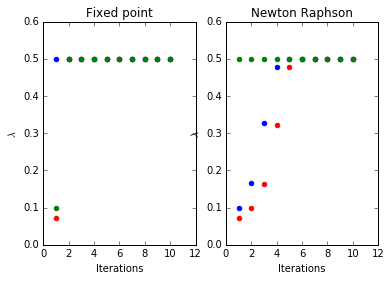

In [95]:
# Make plots


fig, axes = plt.subplots(nrows=1,ncols=2)

iterations = np.array(range(1,max_iter + 1))

axes[0].set_title('Fixed point')
axes[0].scatter(iterations, lambda_fp[0,:],color='r')
axes[0].scatter(iterations, lambda_fp[1,:],color='b')
axes[0].scatter(iterations, lambda_fp[2,:],color='g')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel(r'$\lambda$')
#iterations[0]

axes[1].set_title('Newton Raphson')
axes[1].scatter(iterations, lambda_nr[0,:],color='r')
axes[1].scatter(iterations, lambda_nr[1,:],color='b')
axes[1].scatter(iterations, lambda_nr[2,:],color='g')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel(r'$\lambda$');

#axes[0].plot(lambda_analytic)
#axes[1].plot(lambda_analytic);



### Problem 3

Using the numerical solution in Q.2, plot some example graphs of inflow ratio and i
nduced 
inflow ratio versus advance ratio in level flight for a series of rotor  angles of attack
(α)
. 
Use both positive and negative angles of attack
(
vary α from 
-
4
° to 8° in 2° increments
)
. 
Explore the effect of initial guess for λ on the numerical solution, and suggest why a single 
unique  initial  condition  may  not  always  be  adequate  (use  both  FP  and  NR  methods). 
Comment on your results.

In [99]:
a_set = np.linspace(-4,8,7)
mu_set = np.linspace(0,0.8)

array([-4., -2.,  0.,  2.,  4.,  6.,  8.])